[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

* This demo solves DoomBasic env with a simple q-learning with experience replay.

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=cuda,floatX=float32

env: THEANO_FLAGS=device=cuda,floatX=float32


In [2]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomBasic-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80,height=80,grayscale=True)

env = make_env()

Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
[2017-06-26 18:47:11,263] Making new env: ppaquette/DoomBasic-v0


In [3]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 5

-10.0 False


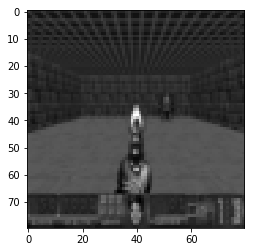

In [4]:
env.reset()
obs,r,done,_=env.step(1)
print(r, done)
plt.imshow(obs[0],cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cuda,floatX=float32

import theano, lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=cuda,floatX=float32


In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
from lasagne.nonlinearities import elu,tanh,softmax
#main neural network body.
#note that we use batch normalization here which speeds up training but may
#get unstable if you use small experience replay buffer
conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [8]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [9]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [10]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 qval.W,
 qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               n_games=N_AGENTS,
               max_size=300) #experience replay pool holding last 1k sessions


[2017-06-26 18:47:12,165] Making new env: ppaquette/DoomBasic-v0


In [13]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

[[2 3 3 2 3 2 0]]
[[-5. -5. -5. -5. -5. -5.  0.]]
CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 85.1 ms


In [14]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [15]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [16]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [17]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [18]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records",record_video=True,n_games=10))

[2017-06-26 18:47:28,930] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:47:28,938] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-06-26 18:47:29,181] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.12348.video000000.mp4


Episode finished after 70 timesteps with reward=-350.0


[2017-06-26 18:47:30,757] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.12348.video000001.mp4


Episode finished after 70 timesteps with reward=-350.0
Episode finished after 70 timesteps with reward=-350.0
Episode finished after 70 timesteps with reward=-350.0
Episode finished after 70 timesteps with reward=-350.0
Episode finished after 70 timesteps with reward=-350.0
Episode finished after 70 timesteps with reward=-350.0


[2017-06-26 18:47:37,763] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.12348.video000008.mp4


Episode finished after 70 timesteps with reward=-350.0
Episode finished after 70 timesteps with reward=-350.0


[2017-06-26 18:47:40,098] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 70 timesteps with reward=-350.0


In [19]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [20]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0:[untrained_reward]}


In [21]:
from tqdm import trange
#the loop may take eons to finish.
#consider interrupting early.
for i in trange(2000):    
    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  0%|          | 10/2000 [00:01<04:27,  7.45it/s]

iter=10	epsilon=0.954	reward/step=-4.63636


  1%|          | 20/2000 [00:02<04:07,  7.99it/s]

iter=20	epsilon=0.910	reward/step=-3.50476


  2%|▏         | 30/2000 [00:03<04:06,  8.00it/s]

iter=30	epsilon=0.868	reward/step=-3.82581


  2%|▏         | 40/2000 [00:04<04:00,  8.13it/s]

iter=40	epsilon=0.828	reward/step=-3.00488


  2%|▎         | 50/2000 [00:06<03:58,  8.17it/s]

iter=50	epsilon=0.790	reward/step=-2.94118


  3%|▎         | 60/2000 [00:07<04:04,  7.93it/s]

iter=60	epsilon=0.754	reward/step=-2.84918


  4%|▎         | 71/2000 [00:08<03:58,  8.09it/s]

iter=70	epsilon=0.719	reward/step=-3.13803


  4%|▍         | 81/2000 [00:09<04:09,  7.69it/s]

iter=80	epsilon=0.687	reward/step=-2.80247


  5%|▍         | 91/2000 [00:11<04:08,  7.67it/s]

iter=90	epsilon=0.656	reward/step=-3.01099


  5%|▍         | 99/2000 [00:12<04:15,  7.43it/s][2017-06-26 18:47:52,550] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:47:52,556] Clearing 8 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.626	reward/step=-2.96832


[2017-06-26 18:47:52,814] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  5%|▌         | 101/2000 [00:12<06:01,  5.25it/s]

Episode finished after 1 timesteps with reward=96.0


  6%|▌         | 111/2000 [00:14<04:20,  7.26it/s]

iter=110	epsilon=0.598	reward/step=-3.12432


  6%|▌         | 121/2000 [00:15<04:22,  7.16it/s]

iter=120	epsilon=0.571	reward/step=-3.23802


  7%|▋         | 131/2000 [00:17<04:24,  7.08it/s]

iter=130	epsilon=0.546	reward/step=-3.16489


  7%|▋         | 141/2000 [00:18<04:26,  6.97it/s]

iter=140	epsilon=0.522	reward/step=-3.14326


  8%|▊         | 151/2000 [00:19<04:42,  6.55it/s]

iter=150	epsilon=0.499	reward/step=-2.96159


  8%|▊         | 161/2000 [00:21<04:47,  6.40it/s]

iter=160	epsilon=0.477	reward/step=-3.05093


  9%|▊         | 171/2000 [00:23<05:07,  5.94it/s]

iter=170	epsilon=0.456	reward/step=-3.01754


  9%|▉         | 181/2000 [00:25<05:16,  5.75it/s]

iter=180	epsilon=0.436	reward/step=-2.98232


 10%|▉         | 191/2000 [00:26<05:21,  5.62it/s]

iter=190	epsilon=0.417	reward/step=-2.96021


 10%|▉         | 199/2000 [00:28<05:29,  5.47it/s][2017-06-26 18:48:08,645] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:48:08,654] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.399	reward/step=-2.94129


[2017-06-26 18:48:09,844] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 10%|█         | 201/2000 [00:29<13:01,  2.30it/s]

Episode finished after 70 timesteps with reward=-415.0


 11%|█         | 211/2000 [00:31<05:38,  5.28it/s]

iter=210	epsilon=0.382	reward/step=-3.01991


 11%|█         | 221/2000 [00:33<05:31,  5.36it/s]

iter=220	epsilon=0.366	reward/step=-3.10045


 12%|█▏        | 231/2000 [00:35<05:32,  5.31it/s]

iter=230	epsilon=0.351	reward/step=-3.16104


 12%|█▏        | 241/2000 [00:37<05:36,  5.23it/s]

iter=240	epsilon=0.336	reward/step=-3.23320


 13%|█▎        | 251/2000 [00:39<05:36,  5.20it/s]

iter=250	epsilon=0.322	reward/step=-3.19124


 13%|█▎        | 261/2000 [00:41<05:41,  5.09it/s]

iter=260	epsilon=0.309	reward/step=-3.08046


 14%|█▎        | 271/2000 [00:43<05:54,  4.88it/s]

iter=270	epsilon=0.296	reward/step=-3.12915


 14%|█▍        | 281/2000 [00:45<05:58,  4.79it/s]

iter=280	epsilon=0.284	reward/step=-3.17082


 15%|█▍        | 291/2000 [00:47<06:00,  4.74it/s]

iter=290	epsilon=0.273	reward/step=-3.21649


 15%|█▍        | 299/2000 [00:49<06:05,  4.66it/s][2017-06-26 18:48:29,772] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:48:29,777] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.262	reward/step=-3.11533


[2017-06-26 18:48:30,168] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 15%|█▌        | 301/2000 [00:50<08:14,  3.43it/s]

Episode finished after 11 timesteps with reward=46.0


 16%|█▌        | 311/2000 [00:52<05:23,  5.22it/s]

iter=310	epsilon=0.252	reward/step=-2.89200


 16%|█▌        | 321/2000 [00:54<05:21,  5.22it/s]

iter=320	epsilon=0.242	reward/step=-2.75000


 17%|█▋        | 331/2000 [00:55<05:19,  5.23it/s]

iter=330	epsilon=0.232	reward/step=-2.68267


 17%|█▋        | 341/2000 [00:57<05:11,  5.32it/s]

iter=340	epsilon=0.224	reward/step=-2.81733


 18%|█▊        | 351/2000 [00:59<05:14,  5.24it/s]

iter=350	epsilon=0.215	reward/step=-2.73000


 18%|█▊        | 361/2000 [01:01<05:13,  5.22it/s]

iter=360	epsilon=0.207	reward/step=-2.79733


 19%|█▊        | 371/2000 [01:03<05:12,  5.21it/s]

iter=370	epsilon=0.199	reward/step=-2.77733


 19%|█▉        | 381/2000 [01:05<05:02,  5.35it/s]

iter=380	epsilon=0.192	reward/step=-2.78133


 20%|█▉        | 391/2000 [01:07<05:06,  5.24it/s]

iter=390	epsilon=0.185	reward/step=-2.69067


 20%|█▉        | 399/2000 [01:09<05:05,  5.24it/s][2017-06-26 18:48:49,485] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:48:49,490] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.179	reward/step=-2.68733


[2017-06-26 18:48:50,678] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 20%|██        | 401/2000 [01:10<11:45,  2.27it/s]

Episode finished after 70 timesteps with reward=-375.0


 21%|██        | 411/2000 [01:12<05:15,  5.03it/s]

iter=410	epsilon=0.172	reward/step=-2.67733


 21%|██        | 421/2000 [01:14<04:56,  5.33it/s]

iter=420	epsilon=0.166	reward/step=-2.39800


 22%|██▏       | 431/2000 [01:16<04:53,  5.35it/s]

iter=430	epsilon=0.161	reward/step=-2.32600


 22%|██▏       | 441/2000 [01:18<04:56,  5.27it/s]

iter=440	epsilon=0.155	reward/step=-2.22867


 23%|██▎       | 451/2000 [01:20<04:51,  5.31it/s]

iter=450	epsilon=0.150	reward/step=-2.35533


 23%|██▎       | 461/2000 [01:22<04:55,  5.21it/s]

iter=460	epsilon=0.145	reward/step=-2.28133


 24%|██▎       | 471/2000 [01:24<04:45,  5.36it/s]

iter=470	epsilon=0.141	reward/step=-2.33533


 24%|██▍       | 481/2000 [01:26<04:50,  5.22it/s]

iter=480	epsilon=0.136	reward/step=-2.18400


 25%|██▍       | 491/2000 [01:28<04:49,  5.22it/s]

iter=490	epsilon=0.132	reward/step=-2.23200


 25%|██▍       | 499/2000 [01:29<04:49,  5.18it/s][2017-06-26 18:49:09,959] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:49:09,964] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.128	reward/step=-2.06667


[2017-06-26 18:49:10,450] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 25%|██▌       | 501/2000 [01:30<07:28,  3.34it/s]

Episode finished after 18 timesteps with reward=1.0


 26%|██▌       | 511/2000 [01:32<04:49,  5.14it/s]

iter=510	epsilon=0.124	reward/step=-1.97933


 26%|██▌       | 521/2000 [01:34<04:39,  5.28it/s]

iter=520	epsilon=0.121	reward/step=-1.95600


 27%|██▋       | 531/2000 [01:36<04:41,  5.23it/s]

iter=530	epsilon=0.117	reward/step=-1.80133


 27%|██▋       | 541/2000 [01:38<04:36,  5.27it/s]

iter=540	epsilon=0.114	reward/step=-1.78133


 28%|██▊       | 551/2000 [01:40<04:31,  5.33it/s]

iter=550	epsilon=0.111	reward/step=-1.48867


 28%|██▊       | 561/2000 [01:42<04:33,  5.26it/s]

iter=560	epsilon=0.108	reward/step=-1.40000


 29%|██▊       | 571/2000 [01:43<04:32,  5.25it/s]

iter=570	epsilon=0.105	reward/step=-1.32133


 29%|██▉       | 581/2000 [01:45<04:30,  5.24it/s]

iter=580	epsilon=0.102	reward/step=-1.31467


 30%|██▉       | 591/2000 [01:47<04:24,  5.33it/s]

iter=590	epsilon=0.100	reward/step=-1.16667


 30%|██▉       | 599/2000 [01:49<04:28,  5.21it/s][2017-06-26 18:49:29,738] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:49:29,743] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.097	reward/step=-0.94800


[2017-06-26 18:49:30,107] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 30%|███       | 601/2000 [01:50<06:19,  3.69it/s]

Episode finished after 9 timesteps with reward=56.0


 31%|███       | 611/2000 [01:52<04:27,  5.20it/s]

iter=610	epsilon=0.095	reward/step=-1.15467


 31%|███       | 621/2000 [01:53<04:22,  5.26it/s]

iter=620	epsilon=0.093	reward/step=-1.29400


 32%|███▏      | 631/2000 [01:55<04:19,  5.27it/s]

iter=630	epsilon=0.091	reward/step=-1.06533


 32%|███▏      | 641/2000 [01:57<04:18,  5.26it/s]

iter=640	epsilon=0.089	reward/step=-0.83667


 33%|███▎      | 651/2000 [01:59<04:18,  5.22it/s]

iter=650	epsilon=0.087	reward/step=-0.97133


 33%|███▎      | 661/2000 [02:01<04:13,  5.28it/s]

iter=660	epsilon=0.085	reward/step=-0.74600


 34%|███▎      | 671/2000 [02:03<04:09,  5.32it/s]

iter=670	epsilon=0.083	reward/step=-0.60267


 34%|███▍      | 681/2000 [02:05<04:12,  5.23it/s]

iter=680	epsilon=0.082	reward/step=-0.65067


 35%|███▍      | 691/2000 [02:07<04:06,  5.31it/s]

iter=690	epsilon=0.080	reward/step=-0.51267


 35%|███▍      | 699/2000 [02:08<04:10,  5.19it/s][2017-06-26 18:49:49,350] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:49:49,355] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.079	reward/step=-0.35467


[2017-06-26 18:49:49,733] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 35%|███▌      | 701/2000 [02:09<05:57,  3.63it/s]

Episode finished after 10 timesteps with reward=46.0


 36%|███▌      | 711/2000 [02:11<04:09,  5.17it/s]

iter=710	epsilon=0.077	reward/step=-0.34467


 36%|███▌      | 721/2000 [02:13<04:00,  5.31it/s]

iter=720	epsilon=0.076	reward/step=-0.32400


 37%|███▋      | 731/2000 [02:15<03:59,  5.29it/s]

iter=730	epsilon=0.075	reward/step=-0.10667


 37%|███▋      | 741/2000 [02:17<04:01,  5.22it/s]

iter=740	epsilon=0.073	reward/step=-0.24200


 38%|███▊      | 751/2000 [02:19<03:53,  5.35it/s]

iter=750	epsilon=0.072	reward/step=-0.17133


 38%|███▊      | 761/2000 [02:21<03:58,  5.19it/s]

iter=760	epsilon=0.071	reward/step=-0.02933


 39%|███▊      | 771/2000 [02:23<03:53,  5.26it/s]

iter=770	epsilon=0.070	reward/step=0.11533


 39%|███▉      | 781/2000 [02:25<03:47,  5.36it/s]

iter=780	epsilon=0.069	reward/step=0.26333


 40%|███▉      | 791/2000 [02:27<03:51,  5.22it/s]

iter=790	epsilon=0.068	reward/step=0.33400


 40%|███▉      | 799/2000 [02:28<03:50,  5.21it/s][2017-06-26 18:50:09,015] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:50:09,020] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.067	reward/step=0.12467


[2017-06-26 18:50:10,210] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 40%|████      | 801/2000 [02:30<08:52,  2.25it/s]

Episode finished after 70 timesteps with reward=-375.0


 41%|████      | 811/2000 [02:32<03:54,  5.07it/s]

iter=810	epsilon=0.067	reward/step=0.12800


 41%|████      | 821/2000 [02:34<03:46,  5.21it/s]

iter=820	epsilon=0.066	reward/step=0.13133


 42%|████▏     | 831/2000 [02:36<03:37,  5.36it/s]

iter=830	epsilon=0.065	reward/step=0.34667


 42%|████▏     | 841/2000 [02:37<03:40,  5.26it/s]

iter=840	epsilon=0.064	reward/step=0.63600


 43%|████▎     | 851/2000 [02:39<03:37,  5.29it/s]

iter=850	epsilon=0.064	reward/step=0.70333


 43%|████▎     | 861/2000 [02:41<03:37,  5.23it/s]

iter=860	epsilon=0.063	reward/step=0.48467


 44%|████▎     | 871/2000 [02:43<03:34,  5.25it/s]

iter=870	epsilon=0.062	reward/step=0.76400


 44%|████▍     | 881/2000 [02:45<03:34,  5.23it/s]

iter=880	epsilon=0.062	reward/step=0.90267


 45%|████▍     | 891/2000 [02:47<03:30,  5.28it/s]

iter=890	epsilon=0.061	reward/step=0.98000


 45%|████▍     | 899/2000 [02:49<03:31,  5.21it/s][2017-06-26 18:50:29,476] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:50:29,480] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.061	reward/step=0.77800


[2017-06-26 18:50:29,750] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 45%|████▌     | 901/2000 [02:49<04:34,  4.00it/s]

Episode finished after 2 timesteps with reward=91.0


 46%|████▌     | 911/2000 [02:51<03:27,  5.25it/s]

iter=910	epsilon=0.060	reward/step=0.84867


 46%|████▌     | 921/2000 [02:53<03:20,  5.38it/s]

iter=920	epsilon=0.060	reward/step=1.14200


 47%|████▋     | 931/2000 [02:55<03:19,  5.35it/s]

iter=930	epsilon=0.059	reward/step=1.35467


 47%|████▋     | 941/2000 [02:57<03:14,  5.44it/s]

iter=940	epsilon=0.059	reward/step=1.70467


 48%|████▊     | 951/2000 [02:59<03:14,  5.39it/s]

iter=950	epsilon=0.058	reward/step=2.13533


 48%|████▊     | 961/2000 [03:01<03:17,  5.27it/s]

iter=960	epsilon=0.058	reward/step=2.20000


 49%|████▊     | 971/2000 [03:03<03:14,  5.30it/s]

iter=970	epsilon=0.057	reward/step=2.20800


 49%|████▉     | 981/2000 [03:04<03:10,  5.34it/s]

iter=980	epsilon=0.057	reward/step=2.56467


 50%|████▉     | 991/2000 [03:06<03:06,  5.42it/s]

iter=990	epsilon=0.057	reward/step=2.78000


 50%|████▉     | 999/2000 [03:08<03:09,  5.29it/s][2017-06-26 18:50:48,739] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:50:48,743] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.056	reward/step=3.06267


[2017-06-26 18:50:49,146] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 50%|█████     | 1001/2000 [03:09<04:35,  3.62it/s]

Episode finished after 12 timesteps with reward=41.0


 51%|█████     | 1011/2000 [03:11<03:10,  5.18it/s]

iter=1010	epsilon=0.056	reward/step=3.20400


 51%|█████     | 1021/2000 [03:12<03:00,  5.42it/s]

iter=1020	epsilon=0.056	reward/step=3.41533


 52%|█████▏    | 1031/2000 [03:14<02:59,  5.41it/s]

iter=1030	epsilon=0.056	reward/step=3.56333


 52%|█████▏    | 1041/2000 [03:16<02:58,  5.37it/s]

iter=1040	epsilon=0.055	reward/step=4.05200


 53%|█████▎    | 1051/2000 [03:18<02:54,  5.45it/s]

iter=1050	epsilon=0.055	reward/step=4.69467


 53%|█████▎    | 1061/2000 [03:20<02:55,  5.37it/s]

iter=1060	epsilon=0.055	reward/step=4.91600


 54%|█████▎    | 1071/2000 [03:22<02:52,  5.40it/s]

iter=1070	epsilon=0.055	reward/step=5.26933


 54%|█████▍    | 1081/2000 [03:24<02:51,  5.37it/s]

iter=1080	epsilon=0.054	reward/step=5.26333


 55%|█████▍    | 1091/2000 [03:26<02:48,  5.41it/s]

iter=1090	epsilon=0.054	reward/step=5.68200


 55%|█████▍    | 1099/2000 [03:27<02:50,  5.27it/s][2017-06-26 18:51:08,063] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:51:08,067] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.054	reward/step=6.17000


[2017-06-26 18:51:08,391] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 55%|█████▌    | 1101/2000 [03:28<03:51,  3.89it/s]

Episode finished after 6 timesteps with reward=71.0


 56%|█████▌    | 1111/2000 [03:30<02:48,  5.29it/s]

iter=1110	epsilon=0.054	reward/step=6.45600


 56%|█████▌    | 1121/2000 [03:32<02:44,  5.33it/s]

iter=1120	epsilon=0.054	reward/step=6.88000


 57%|█████▋    | 1131/2000 [03:34<02:43,  5.31it/s]

iter=1130	epsilon=0.053	reward/step=7.08867


 57%|█████▋    | 1141/2000 [03:35<02:38,  5.40it/s]

iter=1140	epsilon=0.053	reward/step=7.30400


 58%|█████▊    | 1151/2000 [03:37<02:36,  5.43it/s]

iter=1150	epsilon=0.053	reward/step=7.44867


 58%|█████▊    | 1161/2000 [03:39<02:34,  5.42it/s]

iter=1160	epsilon=0.053	reward/step=8.01733


 59%|█████▊    | 1171/2000 [03:41<02:34,  5.36it/s]

iter=1170	epsilon=0.053	reward/step=8.23467


 59%|█████▉    | 1181/2000 [03:43<02:32,  5.36it/s]

iter=1180	epsilon=0.053	reward/step=8.59733


 60%|█████▉    | 1191/2000 [03:45<02:29,  5.40it/s]

iter=1190	epsilon=0.052	reward/step=8.95400


 60%|█████▉    | 1199/2000 [03:46<02:30,  5.32it/s][2017-06-26 18:51:27,274] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:51:27,279] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.052	reward/step=9.44867


[2017-06-26 18:51:27,615] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 60%|██████    | 1201/2000 [03:47<03:27,  3.86it/s]

Episode finished after 7 timesteps with reward=66.0


 61%|██████    | 1211/2000 [03:49<02:29,  5.28it/s]

iter=1210	epsilon=0.052	reward/step=10.02067


 61%|██████    | 1221/2000 [03:51<02:26,  5.33it/s]

iter=1220	epsilon=0.052	reward/step=10.09067


 62%|██████▏   | 1231/2000 [03:53<02:23,  5.34it/s]

iter=1230	epsilon=0.052	reward/step=9.94533


 62%|██████▏   | 1241/2000 [03:55<02:21,  5.35it/s]

iter=1240	epsilon=0.052	reward/step=9.80067


 63%|██████▎   | 1251/2000 [03:57<02:20,  5.33it/s]

iter=1250	epsilon=0.052	reward/step=9.86667


 63%|██████▎   | 1261/2000 [03:58<02:17,  5.38it/s]

iter=1260	epsilon=0.052	reward/step=10.14933


 64%|██████▎   | 1271/2000 [04:00<02:17,  5.31it/s]

iter=1270	epsilon=0.052	reward/step=10.35467


 64%|██████▍   | 1281/2000 [04:02<02:14,  5.35it/s]

iter=1280	epsilon=0.052	reward/step=10.35467


 65%|██████▍   | 1291/2000 [04:04<02:13,  5.33it/s]

iter=1290	epsilon=0.052	reward/step=10.42867


 65%|██████▍   | 1299/2000 [04:06<02:12,  5.28it/s][2017-06-26 18:51:46,549] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:51:46,553] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.051	reward/step=10.35867


[2017-06-26 18:51:46,887] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 65%|██████▌   | 1301/2000 [04:06<03:02,  3.83it/s]

Episode finished after 7 timesteps with reward=66.0


 66%|██████▌   | 1311/2000 [04:08<02:09,  5.33it/s]

iter=1310	epsilon=0.051	reward/step=10.64467


 66%|██████▌   | 1321/2000 [04:10<02:08,  5.30it/s]

iter=1320	epsilon=0.051	reward/step=10.71533


 67%|██████▋   | 1331/2000 [04:12<02:04,  5.39it/s]

iter=1330	epsilon=0.051	reward/step=10.64467


 67%|██████▋   | 1341/2000 [04:14<02:01,  5.44it/s]

iter=1340	epsilon=0.051	reward/step=10.78933


 68%|██████▊   | 1351/2000 [04:16<02:01,  5.34it/s]

iter=1350	epsilon=0.051	reward/step=10.50667


 68%|██████▊   | 1361/2000 [04:18<01:59,  5.36it/s]

iter=1360	epsilon=0.051	reward/step=10.50000


 69%|██████▊   | 1371/2000 [04:20<01:57,  5.36it/s]

iter=1370	epsilon=0.051	reward/step=10.50333


 69%|██████▉   | 1381/2000 [04:22<01:54,  5.40it/s]

iter=1380	epsilon=0.051	reward/step=10.49600


 70%|██████▉   | 1391/2000 [04:23<01:53,  5.38it/s]

iter=1390	epsilon=0.051	reward/step=10.56867


 70%|██████▉   | 1399/2000 [04:25<01:51,  5.38it/s][2017-06-26 18:52:05,775] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:52:05,779] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.051	reward/step=10.63667


[2017-06-26 18:52:06,074] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 70%|███████   | 1401/2000 [04:26<02:29,  4.00it/s]

Episode finished after 4 timesteps with reward=81.0


 71%|███████   | 1411/2000 [04:27<01:50,  5.32it/s]

iter=1410	epsilon=0.051	reward/step=10.70400


 71%|███████   | 1421/2000 [04:29<01:47,  5.41it/s]

iter=1420	epsilon=0.051	reward/step=10.84533


 72%|███████▏  | 1431/2000 [04:31<01:46,  5.36it/s]

iter=1430	epsilon=0.051	reward/step=10.77800


 72%|███████▏  | 1441/2000 [04:33<01:43,  5.41it/s]

iter=1440	epsilon=0.051	reward/step=10.77800


 73%|███████▎  | 1451/2000 [04:35<01:41,  5.41it/s]

iter=1450	epsilon=0.051	reward/step=10.70400


 73%|███████▎  | 1461/2000 [04:37<01:40,  5.36it/s]

iter=1460	epsilon=0.051	reward/step=10.63667


 74%|███████▎  | 1471/2000 [04:39<01:38,  5.34it/s]

iter=1470	epsilon=0.051	reward/step=10.56600


 74%|███████▍  | 1481/2000 [04:41<01:37,  5.34it/s]

iter=1480	epsilon=0.051	reward/step=10.48533


 75%|███████▍  | 1491/2000 [04:43<01:33,  5.47it/s]

iter=1490	epsilon=0.051	reward/step=10.55267


 75%|███████▍  | 1499/2000 [04:44<01:35,  5.26it/s][2017-06-26 18:52:24,970] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:52:24,974] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.051	reward/step=10.26333


[2017-06-26 18:52:25,309] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 75%|███████▌  | 1501/2000 [04:45<02:11,  3.80it/s]

Episode finished after 7 timesteps with reward=62.0


 76%|███████▌  | 1511/2000 [04:47<01:31,  5.33it/s]

iter=1510	epsilon=0.050	reward/step=10.05133


 76%|███████▌  | 1521/2000 [04:49<01:28,  5.41it/s]

iter=1520	epsilon=0.050	reward/step=10.26333


 77%|███████▋  | 1531/2000 [04:50<01:28,  5.32it/s]

iter=1530	epsilon=0.050	reward/step=10.19600


 77%|███████▋  | 1541/2000 [04:52<01:25,  5.40it/s]

iter=1540	epsilon=0.050	reward/step=10.27333


 78%|███████▊  | 1551/2000 [04:54<01:22,  5.42it/s]

iter=1550	epsilon=0.050	reward/step=10.27467


 78%|███████▊  | 1561/2000 [04:56<01:21,  5.38it/s]

iter=1560	epsilon=0.050	reward/step=10.20667


 79%|███████▊  | 1571/2000 [04:58<01:18,  5.47it/s]

iter=1570	epsilon=0.050	reward/step=10.27867


 79%|███████▉  | 1581/2000 [05:00<01:18,  5.36it/s]

iter=1580	epsilon=0.050	reward/step=10.42333


 80%|███████▉  | 1591/2000 [05:02<01:16,  5.37it/s]

iter=1590	epsilon=0.050	reward/step=10.42333


 80%|███████▉  | 1599/2000 [05:03<01:16,  5.28it/s][2017-06-26 18:52:44,186] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:52:44,191] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1600	epsilon=0.050	reward/step=10.42600


[2017-06-26 18:52:44,513] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 80%|████████  | 1601/2000 [05:04<01:42,  3.90it/s]

Episode finished after 6 timesteps with reward=71.0


 81%|████████  | 1611/2000 [05:06<01:13,  5.31it/s]

iter=1610	epsilon=0.050	reward/step=10.56733


 81%|████████  | 1621/2000 [05:08<01:10,  5.38it/s]

iter=1620	epsilon=0.050	reward/step=10.56400


 82%|████████▏ | 1631/2000 [05:10<01:09,  5.34it/s]

iter=1630	epsilon=0.050	reward/step=10.49400


 82%|████████▏ | 1641/2000 [05:12<01:06,  5.37it/s]

iter=1640	epsilon=0.050	reward/step=10.13667


 83%|████████▎ | 1651/2000 [05:14<01:06,  5.27it/s]

iter=1650	epsilon=0.050	reward/step=9.99200


 83%|████████▎ | 1661/2000 [05:15<01:04,  5.24it/s]

iter=1660	epsilon=0.050	reward/step=9.56133


 84%|████████▎ | 1671/2000 [05:17<01:02,  5.30it/s]

iter=1670	epsilon=0.050	reward/step=9.13467


 84%|████████▍ | 1681/2000 [05:19<01:00,  5.25it/s]

iter=1680	epsilon=0.050	reward/step=8.78467


 85%|████████▍ | 1691/2000 [05:21<00:58,  5.33it/s]

iter=1690	epsilon=0.050	reward/step=8.43800


 85%|████████▍ | 1699/2000 [05:23<00:56,  5.31it/s][2017-06-26 18:53:03,577] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:53:03,581] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1700	epsilon=0.050	reward/step=8.37067


[2017-06-26 18:53:03,903] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 85%|████████▌ | 1701/2000 [05:23<01:16,  3.90it/s]

Episode finished after 6 timesteps with reward=71.0


 86%|████████▌ | 1711/2000 [05:25<00:54,  5.33it/s]

iter=1710	epsilon=0.050	reward/step=8.57933


 86%|████████▌ | 1721/2000 [05:27<00:52,  5.30it/s]

iter=1720	epsilon=0.050	reward/step=8.37067


 87%|████████▋ | 1731/2000 [05:29<00:50,  5.32it/s]

iter=1730	epsilon=0.050	reward/step=8.14867


 87%|████████▋ | 1741/2000 [05:31<00:49,  5.26it/s]

iter=1740	epsilon=0.050	reward/step=7.79533


 88%|████████▊ | 1751/2000 [05:33<00:47,  5.27it/s]

iter=1750	epsilon=0.050	reward/step=7.29733


 88%|████████▊ | 1761/2000 [05:35<00:45,  5.31it/s]

iter=1760	epsilon=0.050	reward/step=7.01467


 89%|████████▊ | 1771/2000 [05:37<00:42,  5.34it/s]

iter=1770	epsilon=0.050	reward/step=6.87400


 89%|████████▉ | 1781/2000 [05:39<00:40,  5.35it/s]

iter=1780	epsilon=0.050	reward/step=6.59467


 90%|████████▉ | 1791/2000 [05:41<00:39,  5.35it/s]

iter=1790	epsilon=0.050	reward/step=6.30867


 90%|████████▉ | 1799/2000 [05:42<00:38,  5.23it/s][2017-06-26 18:53:22,981] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:53:22,986] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1800	epsilon=0.050	reward/step=6.03600


[2017-06-26 18:53:23,294] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 90%|█████████ | 1801/2000 [05:43<00:51,  3.88it/s]

Episode finished after 5 timesteps with reward=76.0


 91%|█████████ | 1811/2000 [05:45<00:36,  5.24it/s]

iter=1810	epsilon=0.050	reward/step=5.81733


 91%|█████████ | 1821/2000 [05:47<00:33,  5.36it/s]

iter=1820	epsilon=0.050	reward/step=5.31267


 92%|█████████▏| 1831/2000 [05:49<00:31,  5.38it/s]

iter=1830	epsilon=0.050	reward/step=5.45733


 92%|█████████▏| 1841/2000 [05:50<00:29,  5.33it/s]

iter=1840	epsilon=0.050	reward/step=5.31267


 93%|█████████▎| 1851/2000 [05:52<00:27,  5.34it/s]

iter=1850	epsilon=0.050	reward/step=5.02333


 93%|█████████▎| 1861/2000 [05:54<00:26,  5.30it/s]

iter=1860	epsilon=0.050	reward/step=4.60600


 94%|█████████▎| 1871/2000 [05:56<00:24,  5.35it/s]

iter=1870	epsilon=0.050	reward/step=4.18733


 94%|█████████▍| 1881/2000 [05:58<00:22,  5.34it/s]

iter=1880	epsilon=0.050	reward/step=3.82733


 95%|█████████▍| 1891/2000 [06:00<00:20,  5.34it/s]

iter=1890	epsilon=0.050	reward/step=3.61533


 95%|█████████▍| 1899/2000 [06:01<00:19,  5.30it/s][2017-06-26 18:53:42,363] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:53:42,367] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1900	epsilon=0.050	reward/step=3.40333


[2017-06-26 18:53:42,689] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 95%|█████████▌| 1901/2000 [06:02<00:25,  3.86it/s]

Episode finished after 6 timesteps with reward=71.0


 96%|█████████▌| 1911/2000 [06:04<00:16,  5.25it/s]

iter=1910	epsilon=0.050	reward/step=3.05000


 96%|█████████▌| 1921/2000 [06:06<00:15,  5.26it/s]

iter=1920	epsilon=0.050	reward/step=2.55867


 97%|█████████▋| 1931/2000 [06:08<00:13,  5.24it/s]

iter=1930	epsilon=0.050	reward/step=2.27533


 97%|█████████▋| 1941/2000 [06:10<00:11,  5.30it/s]

iter=1940	epsilon=0.050	reward/step=1.99600


 98%|█████████▊| 1951/2000 [06:12<00:09,  5.29it/s]

iter=1950	epsilon=0.050	reward/step=1.79067


 98%|█████████▊| 1961/2000 [06:14<00:07,  5.30it/s]

iter=1960	epsilon=0.050	reward/step=1.80733


 99%|█████████▊| 1971/2000 [06:16<00:05,  5.30it/s]

iter=1970	epsilon=0.050	reward/step=1.94800


 99%|█████████▉| 1981/2000 [06:18<00:03,  5.31it/s]

iter=1980	epsilon=0.050	reward/step=2.16667


100%|█████████▉| 1991/2000 [06:19<00:01,  5.24it/s]

iter=1990	epsilon=0.050	reward/step=2.09600


100%|█████████▉| 1999/2000 [06:21<00:00,  5.27it/s][2017-06-26 18:54:01,899] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 18:54:01,904] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=1.81600


[2017-06-26 18:54:02,239] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
100%|██████████| 2000/2000 [06:22<00:00,  3.27it/s]

Episode finished after 7 timesteps with reward=66.0


# Evaluating results
 * Here we plot learning curves and sample testimonials

In [36]:
rewards[0] = [-350.]

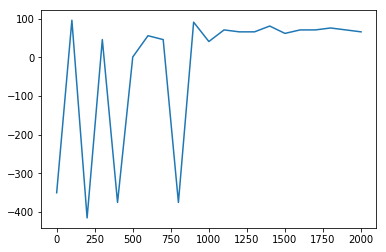

In [40]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,list(map(np.mean,rw)))
    

In [48]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=100,save_path="./records",record_video=True)
print("mean session score=%f.5"%np.mean(rw))

[2017-06-26 19:22:17,341] Making new env: ppaquette/DoomBasic-v0
[2017-06-26 19:22:17,350] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-06-26 19:22:17,589] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.22.12348.video000000.mp4
[2017-06-26 19:22:17,891] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.22.12348.video000001.mp4


Episode finished after 7 timesteps with reward=66.0
Episode finished after 32 timesteps with reward=-63.0
Episode finished after 10 timesteps with reward=51.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 14 timesteps with reward=31.0
Episode finished after 13 timesteps with reward=36.0


[2017-06-26 19:22:19,730] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.22.12348.video000008.mp4


Episode finished after 7 timesteps with reward=66.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 13 timesteps with reward=36.0
Episode finished after 10 timesteps with reward=51.0
Episode finished after 14 timesteps with reward=31.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 8 timesteps with reward=61.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 2 timesteps with reward=91.0
Episode finished after 26 timesteps with reward=-34.0
Episode finished after 12 timesteps with reward=41.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 8 timesteps with reward=56.0
Episode finished after 2 timesteps with reward=91.0
Episode finished after 1 timesteps with reward=96.0
Episode finished after 6 timesteps with reward=71.0
Episode finished after 13 timesteps with reward=36.0


[2017-06-26 19:22:22,161] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.22.12348.video000027.mp4


Episode finished after 4 timesteps with reward=81.0
Episode finished after 9 timesteps with reward=56.0
Episode finished after 1 timesteps with reward=96.0
Episode finished after 15 timesteps with reward=26.0
Episode finished after 10 timesteps with reward=51.0
Episode finished after 17 timesteps with reward=16.0
Episode finished after 6 timesteps with reward=71.0
Episode finished after 12 timesteps with reward=41.0
Episode finished after 1 timesteps with reward=96.0
Episode finished after 18 timesteps with reward=2.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 50 timesteps with reward=-154.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 23 timesteps with reward=-14.0
Episode finished after 18 timesteps with reward=11.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 10 timesteps with reward=51.0
Episode finished after 13 timesteps with reward=36.0
Episode finished after 4 timesteps with reward=81.0


[2017-06-26 19:22:29,453] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.22.12348.video000064.mp4


Episode finished after 46 timesteps with reward=-138.0
Episode finished after 1 timesteps with reward=96.0
Episode finished after 13 timesteps with reward=36.0
Episode finished after 22 timesteps with reward=-24.0
Episode finished after 10 timesteps with reward=51.0
Episode finished after 18 timesteps with reward=2.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 2 timesteps with reward=91.0
Episode finished after 1 timesteps with reward=96.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 33 timesteps with reward=-83.0
Episode finished after 10 timesteps with reward=51.0
Episode finished after 17 timesteps with reward=6.0
Episode finished after 6 timesteps with reward=71.0
Episode finished after 6 timesteps with reward=71.0
Episode finished after 44 timesteps with reward=-119.0
Episode finished after 28 timesteps with reward=-39.0
Episode finished after 7 timesteps with reward=66.0
Episode finished after 14 timesteps with reward=3

[2017-06-26 19:22:35,885] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 8 timesteps with reward=61.0
mean session score=37.980000.5


In [50]:
gym.scoreboard.api_key = 'sk_X6PO6hv9Rq24jaL21xROSA'
gym.upload('/home/ubuntu/records')

[2017-06-26 19:23:30,017] [DoomBasic-v0] Uploading 100 episodes of training data
[2017-06-26 19:23:30,291] [DoomBasic-v0] Uploading videos of 5 training episodes (627611 bytes)
[2017-06-26 19:23:30,522] [DoomBasic-v0] Creating evaluation object from /home/ubuntu/records with learning curve and training video
[2017-06-26 19:23:31,071] 
****************************************************
You successfully uploaded your evaluation on DoomBasic-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_Gm8sr15QTq9fVBuWOFYxg

****************************************************


In [42]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"doombasic_dqn_2000.pcl")

In [43]:
from IPython.display import HTML
import os
from random import choice
#select the one you want
videos = filter(lambda s:s.endswith(".mp4"),os.listdir("./records/"))
video_path="./records/"+choice(videos)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


TypeError: object of type 'filter' has no len()

## Get serious

* Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch or similar
* Deploy a better RL algorithm
* Deploy a better network. Doom will likely need some recurrent nets